# Learning Tic-Tac-Toe with Reinforcement Learning
**_Train with SageMaker RL and evaluate interactively within the notebook_**

---

---


## Outline

1. [Overview](#Overview)
1. [Setup](#Setup)
1. [Code](#Code)
  1. [Environment](#Environment)
  1. [Preset](#Preset)
  1. [Launcher](#Launcher)
1. [Train](#Train)
1. [Deploy](#Deploy)
  1. [Inference](#Inference)
1. [Play](#Play)
1. [Wrap Up](#Wrap-Up)

---

## Overview

Tic-tac-toe is one of the first games children learn to play and was one of the [first computer games ever](https://en.wikipedia.org/wiki/OXO).  Optimal play through exhaustive search is relatively straightforward, however, approaching with a reinforcement learning agent can be educational.

This notebook shows how to train a reinforcement learning agent with SageMaker RL and then play locally and interactively within the notebook.  Unlike SageMaker local mode, this method does not require a docker container to run locally, instead using an endpoint and integration with a small Jupyter app.

---

## Setup

Let's start by defining our S3 bucket and and IAM role.

#### Code Cell 1

In [3]:
import sagemaker

bucket = 'lab-data-bucket-166442528160-326'
role = sagemaker.get_execution_role()

Let's import the libraries we'll use.

#### Code Cell 2

In [4]:
import os
import numpy as np
import sagemaker
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from tic_tac_toe_game import TicTacToeGame

---

## Code

Our tic-tac-toe example requires 3 scripts in order to train our agent using SageMaker RL.  The scripts are placed in the `./src` directory which is sent to the container when the SageMaker training job is initiated.

### Environment

For our tic-tac-toe use case we'll create a custom Gym environment.  This means we'll specify a Python class which inherits from `gym.Env` and has two methods: `reset()` and `step()`.  These will provide the agent its state, actions, and rewards for learning.  In more detail:

The `__init__()` method is called at the beginning of the SageMaker training job and:
1. Starts the 3x3 tic-tac-toe board as a NumPy array of zeros
1. Prepares the state space as a flattened version of the board (length 9)
1. Defines a discrete action space with 9 possible options (one for each place on the board)

The `reset()` method is called at the beginning of each episode and:
1. Clears the 3x3 board (sets all values to 0)
1. Does some minor record-keeping for tracking across tic-tac-toe games

The `step()` method is called for each iteration in an episode and:
1. Adjusts the board based on the action chosen by the agent based on the previous state
1. Generates rewards based on performance
1. Automatically chooses the move for the agent's opponent if needed

Note:
* The opponent has not been programmed for perfect play.  If we taught our agent against a perfect opponent, it would not generalize to scenarios where the rules of perfect play were not followed.
* If our agent selects an occupied space, it is given a minor penalty (-0.1) and asked to choose again.  Although the state doesn't change across these steps (meaning the agent's network's prediction should stay the same), randomness in the agent should eventually result in different actions.  However, if the agent chooses an occupied space 10 times in a row, the game is forfeit.  Selecting an action only from available spaces would require more substantial modification than was desired for this example.
* Other rewards only occur when a game is completed (+1 for win, 0 for draw, -1 for loss).
* The board is saved as a NumPy array where a value of +1 represents our agent's moves (`X`s) and a value of -1 represents the opponent's moves (`O`s).

#### Code Cell 3

In [5]:
!pygmentize ./src/tic_tac_toe.py

import os
import time

import gym
import numpy as np
from gym import spaces


class TicTacToeEnv(gym.Env):
    def __init__(self, opponent="moderate"):
        self.opponent = opponent
        self.episode = 0
        self.observation_space = spaces.Box(low=-1, high=1, shape=(9,), dtype=np.int)
        self.action_space = spaces.Discrete(9)

    def reset(self):
        self.episode += 1
        self.total_reward = 0
        self.occupied = 0
        self.board = np.zeros((3, 3))
        state = self.board.flatten()
        return state

    def step(self, action):

        # Convert action into board position
        row = action // 3
        col = action % 3

        # If agent picks an occupied space repeated end the game and give a penalty
        # Otherwise, give a small penalty and try again
        if self.board[row, col] != 0:
            self.occupied += 1
            if self.occupied > 10:
                reward = -1
                self.total_reward += reward
              

### Preset

The preset file specifies Coach parameters used by our reinforcement learning agent.  For this problem we'll use a [Clipped PPO algorithm](https://nervanasystems.github.io/coach/components/agents/policy_optimization/cppo.html).  We have kept the preset file deliberately spartan, deferring to defaults for most parameters, in order to focus on just the key components.  Performance of our agent could likely be improved with increased tuning.

#### Code Cell 4

In [6]:
!pygmentize ./src/preset.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.base_parameters import PresetValidationParameters, VisualizationParameters
from rl_coach.core_types import EnvironmentEpisodes, EnvironmentSteps, TrainingSteps
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(5000)
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(200)
schedule_params.evaluation_steps = EnvironmentEpisodes(5)
schedule_params.heatup_steps = EnvironmentSteps(0)

#########
# Agent #
#########

agent_params = ClippedPPOAgentParameters()
agent_params.network_wrappers["main"].middleware_parameters.activation_function = "relu"
agent_params.network_wrappers["ma

### Launcher

The launcher is a script used by Amazon SageMaker to drive the training job on the SageMaker RL container.  We have kept it minimal, only specifying the name of the preset file to be used for the training job.

#### Code Cell 5

In [7]:
!pygmentize ./src/train-coach.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher


class MyLauncher(SageMakerCoachPresetLauncher):
    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return "preset"


if __name__ == "__main__":
    MyLauncher.train_main()


---

## Train

Now, let's kick off the training job in Amazon SageMaker.  This call can include hyperparameters that overwrite values in `train-coach.py` or `preset.py`, but in our case, we've limited to defining:
1. The location of our agent code `./src` and dependencies in `common`.
1. Which RL and DL framework to use (SageMaker also supports [Ray RLlib](https://ray.readthedocs.io/en/latest/rllib.html) and Coach TensorFlow).
1. The IAM role granted permissions to our data in S3 and ability to create SageMaker training jobs.
1. Training job hardware specifications (in this case just 1 ml.m4.xlarge instance).
1. Output path for our checkpoints and saved episodes.
1. A single hyperparameter specifying that we would like our agent's network to be output (in this case as an ONNX model).

#### Code Cell 6

In [8]:
estimator = RLEstimator(
    source_dir="src",
    entry_point="train-coach.py",
    dependencies=["common/sagemaker_rl"],
    toolkit=RLToolkit.COACH,
    toolkit_version="0.11.0",
    framework=RLFramework.MXNET,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/".format(bucket),
    base_job_name="DEMO-rl-tic-tac-toe",
    hyperparameters={"save_model": 1},
)

estimator.fit()

INFO:sagemaker:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating training-job with name: DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100


2023-06-18 12:53:26 Starting - Starting the training job...
2023-06-18 12:54:00 Starting - Preparing the instances for training.........
2023-06-18 12:55:23 Downloading - Downloading input data...
2023-06-18 12:56:03 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-18 12:56:19,864 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2023-06-18 12:56:19,868 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-06-18 12:56:19,883 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_CHANNELS': '[]', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_FRAMEWORK_MODULE': 'sagemaker_mxnet_container.training:main', 'SM_USER_ARGS': '["--save_model","1"]', 'SM_HPS': '{"save_model":1}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","cur

## Store intermediate training output and model checkpoints

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training. We'll need these metadata for metrics visualization and model evaluations.


#### Code Cell 7

In [9]:
job_name = estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(bucket, job_name)

output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))

tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100
S3 job path: s3://lab-data-bucket-166442528160-326/DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100
Output.tar.gz location: s3://lab-data-bucket-166442528160-326/DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100/output/output.tar.gz
Intermediate folder path: s3://lab-data-bucket-166442528160-326/DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100/output/intermediate/
Create local folder /tmp/DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100


## Visualization

### Plot metrics for training job

We can pull the reward metric of the training and plot it to see the performance of the model over time.


#### Code Cell 8

INFO:matplotlib.font_manager:generated new fontManager


Waiting for s3://lab-data-bucket-166442528160-326/DEMO-rl-tic-tac-toe-2023-06-18-12-53-26-100/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


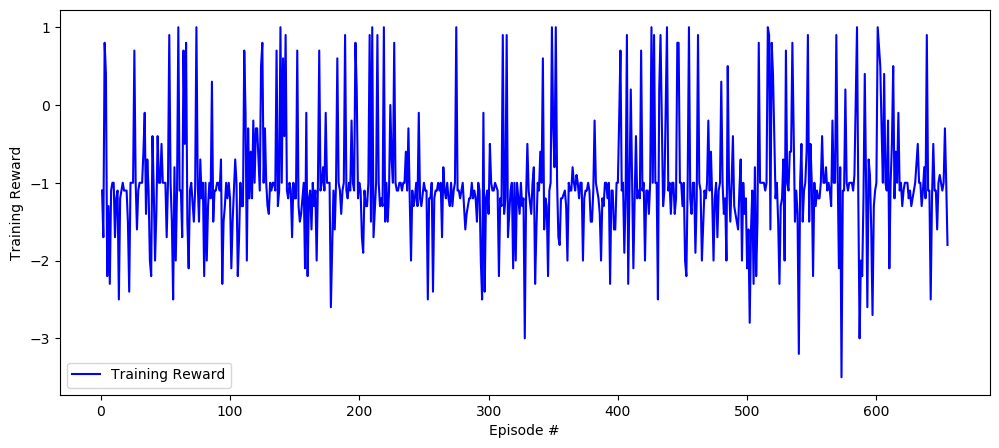

In [10]:
%matplotlib inline
import sys
import os
sys.path.append("common")
import pandas as pd
from misc import wait_for_s3_object

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=["Training Reward"])
x_axis = "Episode #"
y_axis = "Training Reward"

if len(df) > 0:
    plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
    plt.set_ylabel(y_axis)
    plt.set_xlabel(x_axis)

In the Plot you can see the training reward over the number of episodes.



---

## Deploy

Now we are testing for more tangible approach of testing the trained agent by playing against it ourselves.  To do that, we'll first deploy the agent to a realtime endpoint to get predictions.

### Inference

Our deployment code:
1. Unpacks the ONNX model output and prepares it for inference in `model_fn`
1. Generates predictions from our network, given state (a flattened tic-tac-toe board) in `transform_fn`

#### Code Cell 9

In [11]:
!pygmentize ./src/deploy-coach.py

import json
import os

import mxnet as mx
import numpy as np
from mxnet import gluon, nd
from mxnet.contrib import onnx as onnx_mxnet


def model_fn(model_dir):
    """
    Load the onnx model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model
    """
    onnx_path = os.path.join(model_dir, "model.onnx")
    ctx = mx.cpu()  # todo: pass into function
    # load onnx model symbol and parameters
    sym, arg_params, aux_params = onnx_mxnet.import_model(onnx_path)
    model_metadata = onnx_mxnet.get_model_metadata(onnx_path)
    # first index is name, second index is shape
    input_names = [inputs[0] for inputs in model_metadata.get("input_tensor_data")]
    input_symbols = [mx.sym.var(i) for i in input_names]
    net = gluon.nn.SymbolBlock(outputs=sym, inputs=input_symbols)
    net_params = net.collect_params()
    # set parameters (on correct context)
    for param in arg_params:
        if param in net_para

### Endpoint

Now we'll actually create a SageMaker endpoint to call for predictions.

*Note, this step could be replaced by importing the ONNX model into the notebook environment.*

#### Code Cell 10

In [15]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", entry_point="deploy-coach.py"
)

INFO:sagemaker:Creating model with name: DEMO-rl-tic-tac-toe-2023-06-18-13-30-05-362
INFO:sagemaker:Creating endpoint-config with name DEMO-rl-tic-tac-toe-2023-06-18-13-30-05-362
INFO:sagemaker:Creating endpoint with name DEMO-rl-tic-tac-toe-2023-06-18-13-30-05-362


-----!

---

## Play 

Let's play our agent.  After running the cell below, just click on one the boxes to make your move.  To restart the game, simply execute the cell again.

*This cell uses the `TicTacToeGame` class from `tic_tac_toe_game.py` script to build an extremely basic tic-tac-toe app within a Jupyter notebook.  The opponents moves are generated by invoking the `predictor` passed at initialization.  Please refer to the code for additional details.*

#### Code Cell 11

In [19]:
t = TicTacToeGame(predictor)
t.start()

---

## Wrap Up

In this notebook we trained a reinforcement learning agent to play a simple game of tic-tac-toe, using a custom Gym environment.  It could be built upon to solve other problems or improved by:

- Training for more episodes
- Using a different reinforcement learning algorithm
- Tuning hyperparameters for improved performance
- Or how about a nice game of [global thermonuclear war](https://youtu.be/s93KC4AGKnY?t=41)?

Let's finish by cleaning up our endpoint to prevent any persistent costs.

#### Code Cell 12

In [ ]:
#predictor.delete_endpoint()